In [1]:
"""
Created on Mon Feb 20 10:46:10 2023

@author: malcolmw
"""

import devito
import devito_rtm
import hdf5eis
import matplotlib.pyplot as plt
import numpy as np
import pathlib

PRECISION = np.float64

In [30]:
def main():
    config = parse_config()
    model = build_model(config)
    wfs = load_wfs(config['data']['waveform_path'])

    Ws, kernels = build_wavefield_kernels(
        model, 
        wfs, 
        config, 
        n_groups=12
    )
    image, op = build_imaging_operator(model, Ws, kernels)
    print('Starting RTM...')
    op(dt=model.critical_dt)
    print('RTM complete.')
    
    return image, op, wfs

def parse_config():
    config = dict(
        domain=dict(
            shape=(339, 385, 233),      # Number of grid points (nx, ny, nz).
            spacing=(3.125, 3.125, 3.125), # Grid spacing in m (dx, dy, dz).
            origin=(3710571.003824387, 537343.3199534912, 883.6822903108782), # Location of the top-left corner.
            nbl=20,                  # Number of absorbing boundary layers.
            bcs='damp',              # Absorbing boundary type.
            space_order=8,           # Space order of the finite difference stencil.
            time_order=2
        ),
        data=dict(
            waveform_path=pathlib.Path(
                '../data/test-32Hz.hdf5'
            )
        )
    )
    return config


def apply_grouping(wfs, n_groups, strategy):
    if n_groups is None:
        group_ids = np.repeat(0, len(wfs))
    elif isinstance(n_groups, int):
        print(f'Using {strategy} grouping strategy with {n_groups} groups.')
        if strategy == 'random':
            np.random.shuffle(wfs)
        group_ids = np.repeat(
            np.arange(n_groups),
            [len(group) for group in np.array_split(wfs, n_groups)]
        )
    else:
        raise ValueError('`n_groups` must be an int.')

    for group_id in group_ids:
        for wf in wfs[np.nonzero(group_ids == group_id)]:
            wf.group_id = group_id
    
    return wfs, group_ids

def build_model(config):
    vp = 1*np.ones(config['domain']['shape'])
    return devito_rtm.model.SeismicModel(
        vp=vp,
        **{
            key: config['domain'][key]
            for key in (
                'shape', 'spacing', 'origin', 'nbl', 'bcs', 'space_order'
            )
        }
    )

def build_imaging_operator(model, Ws, kernels):
    image = devito.Function(name='Im', grid=model.grid, dtype=PRECISION)
    imaging_kernel = devito.Eq(image, (image + np.prod(Ws)))
    kernels = [eq for kernel in kernels for eq in kernel] + [imaging_kernel]
    op = devito.Operator(
        kernels, 
        subs=model.spacing_map,
        # opt=('advanced', {'openmp': True})
         platform='nvidiaX', opt=('advanced', {'gpu-fit': kernels})
    )
    return image, op


def build_wavefield_kernels(model, wfs, config, n_groups=None, strategy='random'):
    '''
    Build the computational kernels to extrapolate the reverse time-migrated
    wavefield at each station location.

    Parameters
    ----------
    model : devito_rtm.models.SeismicModel
        DESCRIPTION.
    wfs : list
        List of Waveform objects.
    stations: pandas.DataFrame
        DataFrame with station coordinates.
    time_range : devito_rtm.models.TimeAxis
        DESCRIPTION.

    Returns
    -------
    None.

    '''

    Ws = list() # Reverse-time migrated wavefields for each station.
    kernels = list() # Computational kernel for each wavefield extrapolation.
    
    wfs, group_ids = apply_grouping(wfs, n_groups, strategy)

    for group_id in range(n_groups):
        group_wfs = wfs[np.nonzero(group_ids == group_id)]
        time_range = group_wfs[0].time_range
        coords = np.stack([wf.coords for wf in group_wfs])
        data = np.stack([wf.data for wf in group_wfs], axis=1)
        W = devito.TimeFunction(
            name=f'W_{group_id:04d}',
            grid=model.grid,
            time_order=config['domain']['time_order'],
            space_order=config['domain']['space_order'],
            dtype=PRECISION
        )
        Ws.append(W)
        pde = model.m * W.dt2 - W.laplace + model.damp * W.dt
        stencil = devito.Eq(W.forward, devito.solve(pde, W.forward))
        rsrc = devito_rtm.source.PointSource(
            name=f'X_{group_id:04d}',
            grid=model.grid,
            time_range=time_range,
            npoint=len(group_wfs),
            coordinates=coords,
            space_order=config['domain']['space_order'],
            time_order=config['domain']['time_order'],
            dtype=PRECISION
        )
        rsrc.data[:] = data[-1::-1]
        rsrc_term = rsrc.inject(
            field=W.forward, 
            expr=rsrc * time_range.step**2/model.m
        )

        kernels.append([stencil, rsrc_term])

    return Ws, kernels


def _build_wavefield_kernels(model, wfs, config):
    '''
    Build the computational kernels to extrapolate the reverse time-migrated
    wavefield at each station location.

    Parameters
    ----------
    model : devito_rtm.models.SeismicModel
        DESCRIPTION.
    wfs : list
        List of Waveform objects.
    stations: pandas.DataFrame
        DataFrame with station coordinates.
    time_range : devito_rtm.models.TimeAxis
        DESCRIPTION.

    Returns
    -------
    None.

    '''

    Ws = list() # Reverse-time migrated wavefields for each station.
    kernels = list() # Computational kernel for each wavefield extrapolation.
    for i_wf, wf in enumerate(wfs):
        W = devito.TimeFunction(
            name=f'W_{i_wf:04d}',
            grid=model.grid,
            time_order=config['domain']['time_order'],
            space_order=config['domain']['space_order'],
            dtype=PRECISION
        )
        Ws.append(W)
        pde = model.m * W.dt2 - W.laplace + model.damp * W.dt
        stencil = devito.Eq(W.forward, devito.solve(pde, W.forward))
        rsrc = devito_rtm.source.PointSource(
            name=f'X_{i_wf:04d}',
            grid=model.grid,
            time_range=wf.time_range,
            npoint=1,
            coordinates=wf.coords,
            space_order=config['domain']['space_order'],
            time_order=config['domain']['time_order'],
            dtype=PRECISION
        )
        rsrc.data[:] = wf.data[-1::-1, np.newaxis]
        rsrc_term = rsrc.inject(
            field=W.forward, 
            expr=rsrc * wf.time_range.step**2/model.m
        )
        
        kernels.append([stencil, rsrc_term])

    return Ws, kernels


def load_wfs(path):
    '''
    Return waveforms as a dictionary of {station: waveform} pairs.

    Parameters
    ----------
    path : TYPE
        DESCRIPTION.

    Returns
    -------
    wfs : TYPE
        DESCRIPTION.

    '''

    tag = 'synthetic/raw'
    with hdf5eis.File(path, mode='r') as in_file:
        network, _ = in_file.metadata['network']
        network = network.drop_duplicates(subset=['network', 'station'])
        super_gather = in_file.timeseries[tag, ..., 0:1e9]
        gather = super_gather['synthetic/raw'][0]
    network = network.reset_index(drop=True)
    wfs = list()
    
    for (i, row), data in zip(network.iterrows(), gather.data):
        time_range = devito_rtm.source.TimeAxis(
            start=gather.start_time.timestamp(),
            step=gather.sampling_interval,
            num=len(data)
        )
        network_code, station_code, channel_code = row[['network', 'station', 'channel']]
        coords = row[['easting', 'northing', 'z']].values
        channel_code = 'DPZ' if network_code == 'ZG' else 'HHZ'
        seed_id = '.'.join((network_code, station_code, '', channel_code))
        wfs.append(Waveform(
            seed_id,
            data,
            time_range,
            coords
        ))

    return np.array(wfs)


class Waveform:
    def __init__(self, seed_id, data, time_range, coords):
        self.seed_id = seed_id
        self.data = data
        self.time_range = time_range
        self.coords = coords
        
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot(self.data)
        
        
def plot_field(field, src_coords=None, it=None, z_positive_down=False):
    import matplotlib as mpl
    x0, y0, z0 = field.grid.origin
    nx, ny, nz = field.grid.shape
    dx, dy, dz = field.grid.spacing
    xx, yy, zz = np.meshgrid(
        x0 + np.arange(nx)*dx,
        y0 + np.arange(ny)*dy,
        z0 + np.arange(nz)*dz,
        indexing='ij'
    )

    arg_max = np.argmax(np.abs(field.data))
    ix, iy, iz = np.unravel_index(arg_max, field.data.shape)
    img_max = np.array([x0+(ix-1)*dx, y0+(iy-1)*dy, z0+(iz-1)*dz])

    data = field.data if it is None else field.data[it]

    x_range = dx*(nx-1)
    y_range = dy*(ny-1)
    z_range = dz*(nz-1)
    w = [x_range/(x_range+z_range), z_range/(x_range+z_range)]
    h = [y_range/(y_range+z_range), z_range/(y_range+z_range)]
    gs = mpl.gridspec.GridSpec(2, 2, width_ratios=w, height_ratios=h)
    fig = plt.figure(figsize=(12,12))
    ax_xy = fig.add_subplot(gs[0, 0], aspect=1, anchor='SE')
    ax_yz = fig.add_subplot(gs[0, 1], aspect=1, sharey=ax_xy, anchor='SW')
    ax_xz = fig.add_subplot(gs[1, 0], aspect=1, sharex=ax_xy, anchor='NE')
    plt.subplots_adjust(hspace=0, wspace=0)


    amax = np.max(np.abs(data))
    kwargs = dict(
        vmin=-amax,
        vmax=amax,
        cmap=plt.get_cmap('seismic'),
        shading='gouraud'
    )
    ax_xy.pcolormesh(
        xx[:, :, iz],
        yy[:, :, iz],
        data[:, :, iz],
        **kwargs
    )
    ax_xz.pcolormesh(
        xx[:, iy],
        zz[:, iy],
        data[:, iy],
        **kwargs
    )
    ax_yz.pcolormesh(
        zz[ix],
        yy[ix],
        data[ix],
        **kwargs
    )
    for ax, vline, hline in zip(
        (ax_xy, ax_xz, ax_yz),
        img_max[[0, 0, 2]],
        img_max[[1, 2, 1]]
    ):
        ax.axvline(vline, color='k', linewidth=1/2)
        ax.axhline(hline, color='k', linewidth=1/2)
    if src_coords is not None:
        for ax, x0, x1 in zip(
            (ax_xy, ax_xz, ax_yz),
            src_coords[[0, 0, 2]],
            src_coords[[1, 2, 1]]
        ):
            ax.scatter(x0, x1)
        
    ax_xy.xaxis.tick_top()
    ax_yz.xaxis.tick_top()
    ax_yz.yaxis.tick_right()
    if z_positive_down is True:
        ax_xz.invert_yaxis()
    else:
        ax_yz.invert_xaxis()

    return dict(
        ax_xy=ax_xy,
        ax_xz=ax_xz,
        ax_yz=ax_yz
    )

def plot(wf):
    fig, ax = plt.subplots()
    ax.plot(wf.data)

In [31]:
image, op, wfs = main()

Operator `initdamp` ran in 0.15 s


random!
Starting RTM...


Operator `Kernel` ran in 66.67 s


RTM complete.


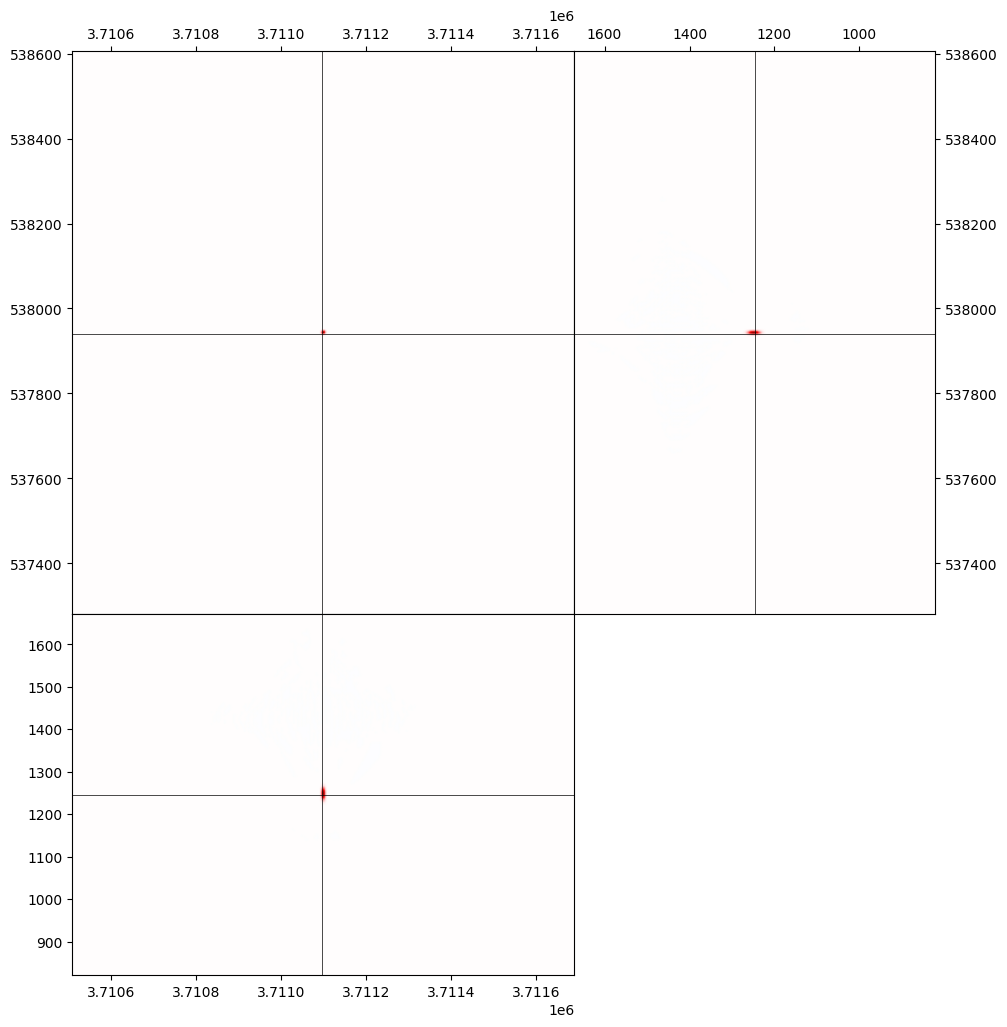

In [33]:
axes = plot_field(
    image, 
    # src_coords=np.array((3711099.9913825006, 537944.2376631803, 1246.641145155439))
)
# for group_wfs in np.array_split(wfs, 12):
#     x = [wf.coords[0] for wf in group_wfs]
#     y = [wf.coords[1] for wf in group_wfs]
#     axes['ax_xy'].scatter(x, y, s=4)

In [26]:
config = parse_config()
model = build_model(config)
wfs = load_wfs(config['data']['waveform_path'])

Operator `initdamp` ran in 0.15 s


In [27]:
n_groups = 12
strategy = 'random'

group_ids, wfs = apply_grouping(wfs, n_groups, strategy)

for group_id in range(n_groups):
    group_wfs = wfs[np.nonzero(group_ids == group_id)]

random!


In [29]:
group_ids

array([<__main__.Waveform object at 0x7f7bb4e370d0>,
       <__main__.Waveform object at 0x7f7bb4d41490>, ...,
       <__main__.Waveform object at 0x7f7bb4d78d30>], dtype=object)

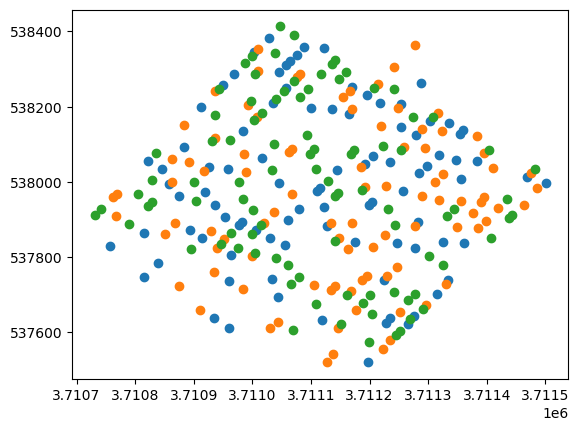

In [23]:
plt.close('all')
fig, ax = plt.subplots()
for wf in wfs:
    if wf.group_id in (0, 1, 2):
        ax.scatter(*wf.coords[:2], color=f'C{wf.group_id}')

In [ ]:
kern = kernels[0][1]

In [ ]:
ker

In [ ]:
wfs[nonzero(group_ids == 1)

In [ ]:
n_groups = 12
n_wfs = len(wfs)

In [ ]:
group_size = int(np.ceil(n_wfs / n_groups))

In [ ]:
[len(l) for l in ]

In [ ]:
v_min/f/dx > 10-20
 
0<v_max dt/dx < 0.495